In [1]:
import pandas as pd
import numpy as np
import akshare as ak
import pandas_market_calendars as mcal
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
from clusters import ClusterAnalyse, SnowballEngine, KmeansEngine, ResultEngine
from tslearn.metrics import dtw
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
plt.rcParams['font.sans-serif']=['Heiti TC']
colors = sns.color_palette('pastel')

In [2]:
snowball_terms = {'type': 'call', 'retention': 0, 'bonus': 0.2, 'annual': 361, 'principal': 1000000,
                      'ki_price': 0.8, 'ki_strike': 1, 'ki_participation': 1, 'ko_price': 1.0, 
                      'ko_participation': 0, 'coupon': 0.2, 'ko_obs_protect': 0}
start_date = '2018-01-01'
end_date = '2019-01-01'
interval = mcal.get_calendar('XSHG').schedule(start_date, end_date).shape[0]       
snowball_engine = SnowballEngine(start_date, end_date, snowball_terms)

In [3]:
index500 = ak.index_stock_cons_csindex(symbol='000905')
code_list = list(index500['成分券代码'].values)

df_info = pd.DataFrame(index=list(range(500)), 
                       columns=['总市值','流通市值','行业','上市时间','股票代码','股票简称','总股本','流通股'])
for _ in range(500):
    code = code_list[_]
    info = ak.stock_individual_info_em(symbol=code)['value']
    df_info.iloc[_] = info

df_info['上市时间'] = pd.to_datetime(df_info['上市时间'], format='%Y%m%d')
df_info['上市年份'] = df_info['上市时间'].dt.year
# 剔除上市年份晚于2017年的个股
df_filter1 = df_info[df_info['上市年份']<=2016].copy()
code_filter_time = list(df_filter1['股票代码'].values)
print('筛选出的个股个数为 ', len(code_filter_time))

# 筛选出平均换手率在1.5%以上的个股
code_filter_list = []
turnover_few_list = []

for _ in range(len(code_filter_time)):
    code = code_filter_time[_]
    df = ak.stock_zh_a_hist(symbol=code, period="daily", start_date="20000101", end_date='20191231', adjust="hfq")
    turnover_mean = df['换手率'].mean()
    if turnover_mean >= 1.5:
        code_filter_list.append(code)
    else:
        turnover_few_list.append(code)
        
print('总共个股数为：', len(code_filter_list))

筛选出的个股个数为  394
总共个股数为： 320


# 1. 样本长度为20

## 1.1 训练集

In [5]:
terms1 = {'sample_length': 20, 'backtest_length': 243, 'num_clusters': 9, 'sliding': False, 'sliding_window': 20}
train_engine1 = ClusterAnalyse(snowball_engine, terms1)


for _ in range(len(code_filter_list)):
    code = code_filter_list[_]
    df = ak.stock_zh_a_hist(symbol=code, period="daily", start_date="20000101", end_date='20191231', adjust="hfq")

    train_engine1.train(df, code, plot=False)

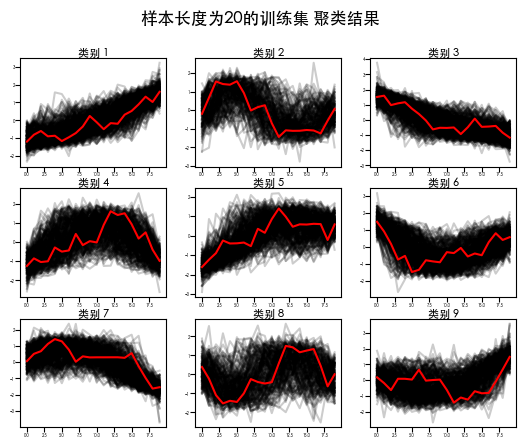

cluster 1 敲入概率: 0.18126757516764005
cluster 2 敲入概率: 0.17165847116674118
cluster 3 敲入概率: 0.161138454953991
cluster 4 敲入概率: 0.16940030753459764
cluster 5 敲入概率: 0.1842769563649477
cluster 6 敲入概率: 0.16751740139211138
cluster 7 敲入概率: 0.16523641258623592
cluster 8 敲入概率: 0.16460701927829954
cluster 9 敲入概率: 0.18256274768824307
总共训练样本数为： 46338


In [6]:
train_engine1.second_cluster(plot=True)
train_engine1.get_knockin_prob(mode='train')
print('总共训练样本数为：', len(train_engine1.snowball_dict))

## 1.2 测试集

In [7]:
test_engine1 = ClusterAnalyse(snowball_engine, terms1)
        
for _ in range(len(code_filter_list)):
    code = code_filter_list[_]
    df = ak.stock_zh_a_hist(symbol=code, period="daily", start_date="20200101", end_date='20221231', adjust="hfq")

    test_engine1.test(df, code, train_engine1)

In [8]:
test_engine1.get_knockin_prob(mode='test')
print('总共测试样本数为：', len(test_engine1.snowball_dict))

cluster 1 敲入概率: 0.19381255686988172
cluster 2 敲入概率: 0.14743589743589744
cluster 3 敲入概率: 0.12976022566995768
cluster 4 敲入概率: 0.1865203761755486
cluster 5 敲入概率: 0.18207282913165265
cluster 6 敲入概率: 0.1492007104795737
cluster 7 敲入概率: 0.11440245148110317
cluster 8 敲入概率: 0.18503118503118504
cluster 9 敲入概率: 0.16580310880829016
总共测试样本数为： 7645


## 1.3 结果对比

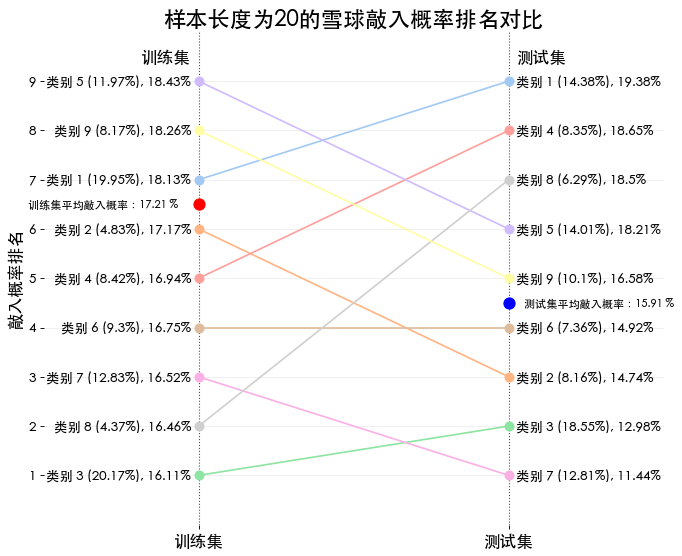

In [9]:
result_engine1 = ResultEngine(train_engine1, test_engine1)
result_engine1.cal_sample_length()
result_engine1.get_rank_df()
result_engine1.get_mean_dict()
result_engine1.plot_result_rank()

- 类别4和类别8属于**交叉**情形，由聚类中心图可以看到，类别4（先增再减）和类别8（先减再增再减）都属于“类拱形”。由此可见，这种类型具有较大不稳定性，因此在后续分析中予以剔除。

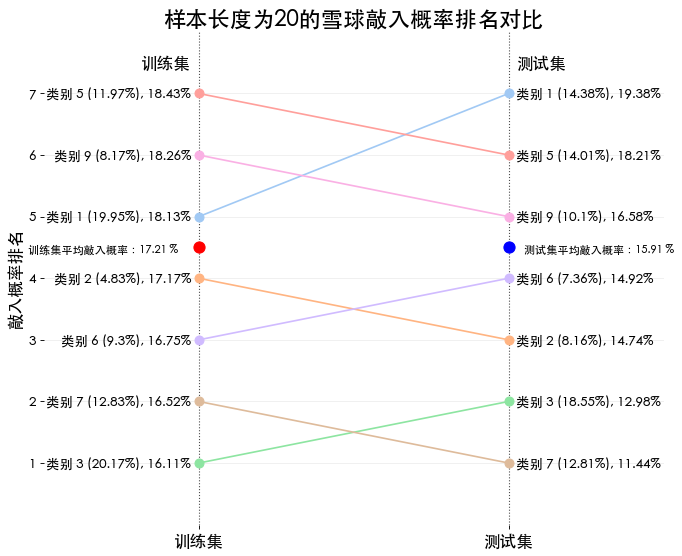

In [10]:
rank1 = result_engine1.rank_result.drop([3,7], axis=0).reset_index(drop=True)
rank1['train_rank'] = rank1['train'].rank()
rank1['test_rank'] = rank1['test'].rank()
result_engine1.rank_result = rank1
result_engine1.get_mean_dict()
result_engine1.plot_result_rank()

# 2. 样本长度为40

## 2.1 训练集

In [11]:
terms2 = {'sample_length': 40, 'backtest_length': 243, 'num_clusters': 9, 'sliding': True, 'sliding_window': 20}
train_engine2 = ClusterAnalyse(snowball_engine, terms2)

for _ in range(len(code_filter_list)):
    code = code_filter_list[_]
    df = ak.stock_zh_a_hist(symbol=code, period="daily", start_date="20000101", end_date='20191231', adjust="hfq")

    train_engine2.train(df, code, plot=False)

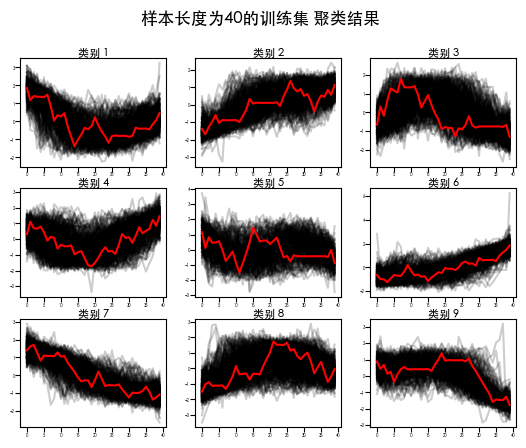

cluster 1 敲入概率: 0.17797783933518005
cluster 2 敲入概率: 0.16486486486486487
cluster 3 敲入概率: 0.18140692151097038
cluster 4 敲入概率: 0.19069975408003578
cluster 5 敲入概率: 0.1849390919158361
cluster 6 敲入概率: 0.18124006359300476
cluster 7 敲入概率: 0.15695600475624258
cluster 8 敲入概率: 0.17391304347826086
cluster 9 敲入概率: 0.14852135815991238
总共训练样本数为： 46018


In [12]:
train_engine2.second_cluster(plot=True)
train_engine2.get_knockin_prob(mode='train')
print('总共训练样本数为：', len(train_engine2.snowball_dict))

## 2.2 测试集

In [14]:
test_engine2 = ClusterAnalyse(snowball_engine, terms2)
        
for _ in range(len(code_filter_list)):
    code = code_filter_list[_]
    df = ak.stock_zh_a_hist(symbol=code, period="daily", start_date="20200101", end_date='20221231', adjust="hfq")

    test_engine2.test(df, code, train_engine2)

In [15]:
test_engine2.get_knockin_prob(mode='test')
print('总共测试样本数为：', len(test_engine2.snowball_dict))

cluster 1 敲入概率: 0.14267015706806283
cluster 2 敲入概率: 0.21818181818181817
cluster 3 敲入概率: 0.14186046511627906
cluster 4 敲入概率: 0.17654639175257733
cluster 5 敲入概率: 0.15658914728682172
cluster 6 敲入概率: 0.19370229007633588
cluster 7 敲入概率: 0.1
cluster 8 敲入概率: 0.1953125
cluster 9 敲入概率: 0.1162280701754386
总共测试样本数为： 7325


## 2.3 结果对比

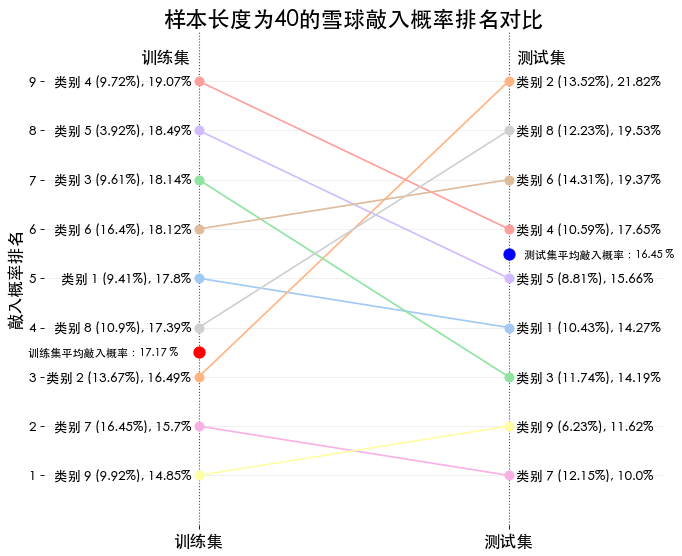

In [16]:
result_engine2 = ResultEngine(train_engine2, test_engine2)
result_engine2.cal_sample_length()
result_engine2.get_rank_df()
result_engine2.get_mean_dict()
result_engine2.plot_result_rank()

- 类别1、2、3和5属于**交叉**情形，这些类型具有较大不稳定性，因此在后续分析中予以剔除。

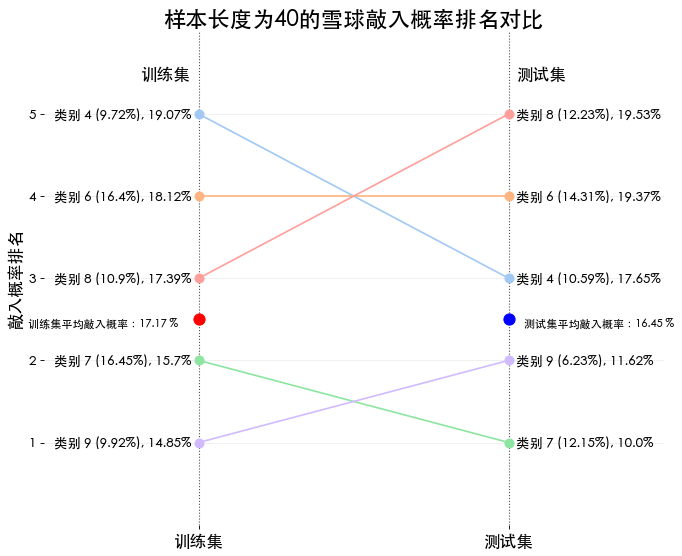

In [17]:
rank2 = result_engine2.rank_result.drop([0,1,2,4], axis=0).reset_index(drop=True)
rank2['train_rank'] = rank2['train'].rank()
rank2['test_rank'] = rank2['test'].rank()
result_engine2.rank_result = rank2
result_engine2.get_mean_dict()
result_engine2.plot_result_rank()

# 3. 样本长度为60

## 3.1 训练集

In [19]:
terms3 = {'sample_length': 60, 'backtest_length': 243, 'num_clusters': 9, 'sliding': True, 'sliding_window': 20}
train_engine3 = ClusterAnalyse(snowball_engine, terms3)

for _ in range(len(code_filter_list)):
    code = code_filter_list[_]
    df = ak.stock_zh_a_hist(symbol=code, period="daily", start_date="20000101", end_date='20191231', adjust="hfq")

    train_engine3.train(df, code, plot=False)

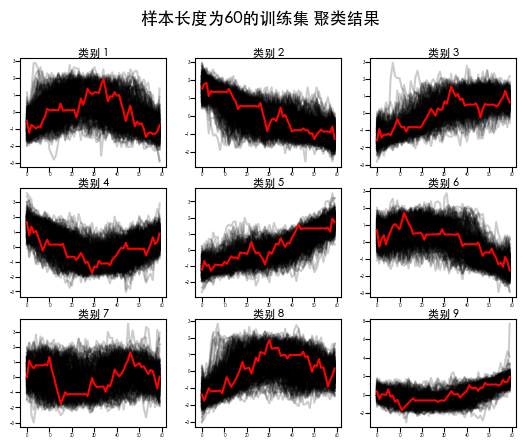

cluster 1 敲入概率: 0.17847705981263512
cluster 2 敲入概率: 0.14695926228551418
cluster 3 敲入概率: 0.18014184397163122
cluster 4 敲入概率: 0.18678949431595454
cluster 5 敲入概率: 0.17182890855457228
cluster 6 敲入概率: 0.15800135043889263
cluster 7 敲入概率: 0.19187062937062938
cluster 8 敲入概率: 0.1855140186915888
cluster 9 敲入概率: 0.1817436458048647
总共训练样本数为： 45698


In [20]:
train_engine3.second_cluster(plot=True)
train_engine3.get_knockin_prob(mode='train')
print('总共训练样本数为：', len(train_engine3.snowball_dict))

## 3.2 测试集

In [21]:
test_engine3 = ClusterAnalyse(snowball_engine, terms3)
        
for _ in range(len(code_filter_list)):
    code = code_filter_list[_]
    df = ak.stock_zh_a_hist(symbol=code, period="daily", start_date="20200101", end_date='20221231', adjust="hfq")

    test_engine3.test(df, code, train_engine3)

In [22]:
test_engine3.get_knockin_prob(mode='test')
print('总共测试样本数为：', len(test_engine3.snowball_dict))

cluster 1 敲入概率: 0.1261682242990654
cluster 2 敲入概率: 0.11883802816901408
cluster 3 敲入概率: 0.22721749696233293
cluster 4 敲入概率: 0.18513119533527697
cluster 5 敲入概率: 0.20446927374301677
cluster 6 敲入概率: 0.11696658097686376
cluster 7 敲入概率: 0.1724137931034483
cluster 8 敲入概率: 0.15558698727015557
cluster 9 敲入概率: 0.19003115264797507
总共测试样本数为： 7005


## 3.3 结果对比

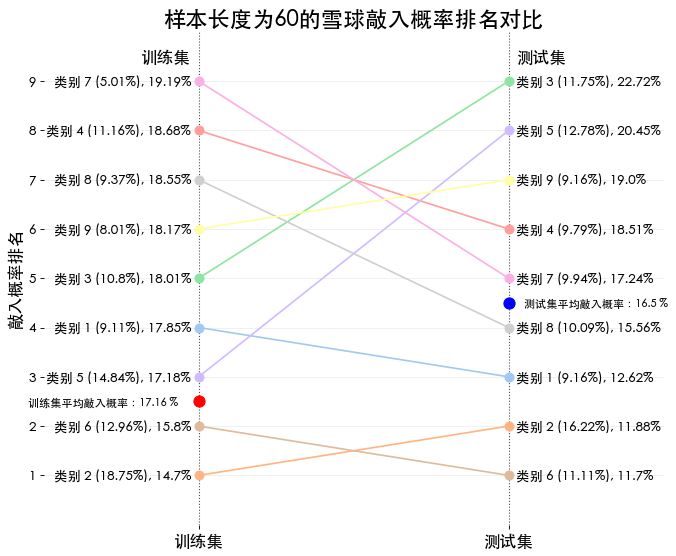

In [23]:
result_engine3 = ResultEngine(train_engine3, test_engine3)
result_engine3.cal_sample_length()
result_engine3.get_rank_df()
result_engine3.get_mean_dict()
result_engine3.plot_result_rank()

- 类别1和8属于**交叉**情形，这些类型具有较大不稳定性，因此在后续分析中予以剔除。

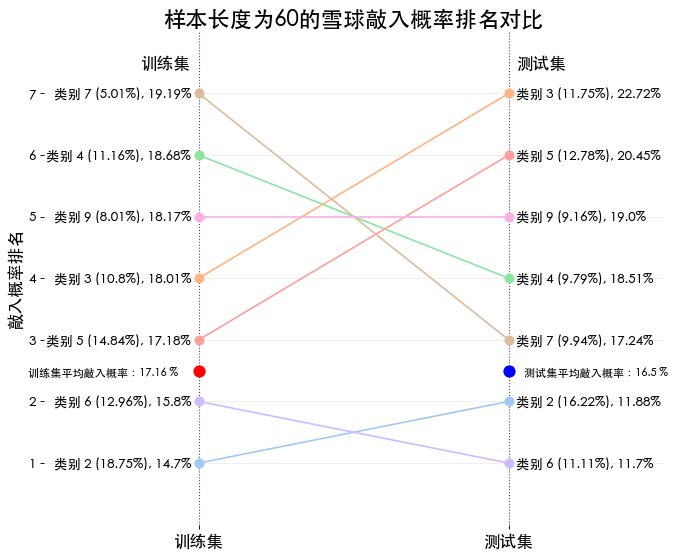

In [24]:
rank3 = result_engine3.rank_result.drop([0,7], axis=0).reset_index(drop=True)
rank3['train_rank'] = rank3['train'].rank()
rank3['test_rank'] = rank3['test'].rank()
result_engine3.rank_result = rank3
result_engine3.get_mean_dict()
result_engine3.plot_result_rank()